In [1]:
#%matplotlib inline
import config.unetConfig as cfg
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
import random

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.utils as vutils

from data import BraTSDataset
from gan.GANTrainer import GANTrainer
from gan.UNetGenerator import UNetGenerator
from gan.UNetDiscriminator import UNetDiscriminator
from IPython.display import HTML
from torch.utils.data import DataLoader
from utils import weights_init_norm, weights_init_ortho, plot_train_metrics

!jupyter nbextension enable --py widgetsnbextension

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Random Seed:  999


## Load the data

> **_NOTE:_**  CHANGE $\underline{BT\_CLASS}$ in the config file to one of $\textbf{["FLAIR", "SEG", "T1CE", "T1", "T2"]}$

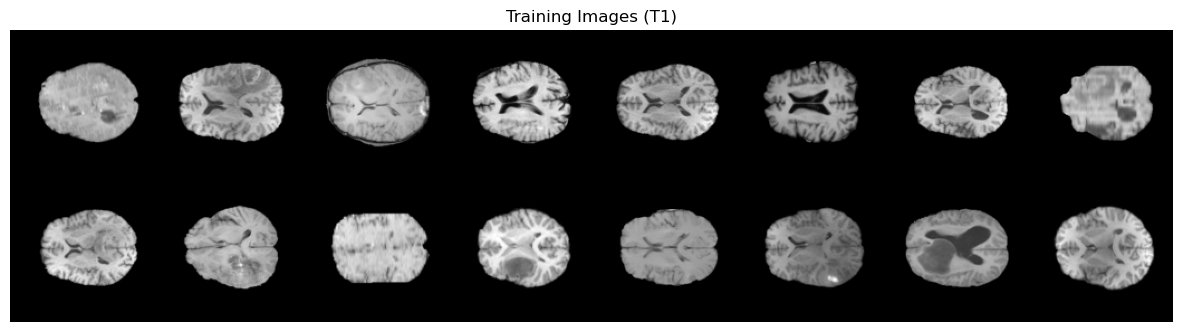

In [2]:
dpath = cfg.DSET_CPATHS[f"{cfg.BT_CLASS}"]

# load the T1 image filepaths in a sorted manner
image_paths = [os.path.join(dpath, impath) for impath in sorted(os.listdir(dpath))]

tf = transforms.Compose([
    transforms.Resize((cfg.INPUT_IMAGE_HEIGHT,cfg.INPUT_IMAGE_WIDTH)),
    transforms.CenterCrop((cfg.INPUT_IMAGE_HEIGHT,cfg.INPUT_IMAGE_WIDTH)),
    transforms.ToTensor(),
    ])

# Create the dataset
dataset = BraTSDataset(image_paths, tf)

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=cfg.BATCH_SIZE,
                        shuffle=True, num_workers=cfg.NUM_WORKERS)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title(f"Training Images ({cfg.BT_CLASS})")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(cfg.DEVICE), normalize=True).cpu(),(1,2,0)))

## Init Generator and weights

In [3]:
# Create the generator
netG = UNetGenerator(cfg.LATENT_SZ, cfg.NGF, cfg.NGC).to(cfg.DEVICE)

# Apply the weights_init_ortho
netG.apply(weights_init_norm)

# Print the model
print(netG)

UNetGenerator(
  (main): Sequential(
    (0): ConvTranspose2d(300, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01, inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
    (1

## Init Discriminator and weights

In [4]:
# Create the Discriminator
netD = UNetDiscriminator(ns=cfg.NEG_SLOPE).to(cfg.DEVICE)

# Apply the weights_init_ortho
netD.apply(weights_init_ortho)

# Print the model
print(netD)

/home/y2k/csc2529-2022-project/src/utils.py:18: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(m.weight.data)


UNetDiscriminator(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): DBlock(
        (main): Sequential(
          (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (1): LeakyReLU(negative_slope=0.2, inplace=True)
          (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
        )
      )
      (1): DBlock(
        (main): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (1): LeakyReLU(negative_slope=0.2, inplace=True)
          (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        )
      )
      (2): DBlock(
        (main): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (1): LeakyReLU(negative_slope=0.2, inplace=True)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        )
      )
    )
    (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (decoder): Decoder(


## Train

In [5]:
trainer = GANTrainer(num_epochs=cfg.NUM_EPOCHS,
                        glr=cfg.GLR, dlr=cfg.DLR,
                        gbeta1=cfg.GBETA1, dbeta1=cfg.DBETA1,
                        dataloader=dataloader,
                        netG=netG, netD=netD,
                        device=cfg.DEVICE)

In [6]:
netG, netD = trainer.train(nz=cfg.LATENT_SZ, batch_sz=cfg.BATCH_SIZE)

Starting Training Loop...
[0/15][0/24]	Loss_D: 1.5039	Loss_G: 0.6832	D(x): 0.4376	D(G(z)): 0.4917 / 0.5051	MPSNR: 7.8986	MSSIM: 0.0040
[0/15][12/24]	Loss_D: 0.8849	Loss_G: 0.9214	D(x): 0.6159	D(G(z)): 0.3045 / 0.4040	MPSNR: 12.6723	MSSIM: 0.0611
[1/15][0/24]	Loss_D: 0.3846	Loss_G: 1.6340	D(x): 0.9105	D(G(z)): 0.2357 / 0.2327	MPSNR: 11.3352	MSSIM: 0.0864
[1/15][12/24]	Loss_D: 0.6553	Loss_G: 1.0765	D(x): 0.9423	D(G(z)): 0.4198 / 0.3709	MPSNR: 9.5088	MSSIM: 0.1928
[2/15][0/24]	Loss_D: 0.9411	Loss_G: 2.4815	D(x): 0.9933	D(G(z)): 0.5921 / 0.1358	MPSNR: 10.0711	MSSIM: 0.1802
[2/15][12/24]	Loss_D: 0.6321	Loss_G: 1.1006	D(x): 0.8974	D(G(z)): 0.4023 / 0.3399	MPSNR: 9.5921	MSSIM: 0.2194
[3/15][0/24]	Loss_D: 0.5574	Loss_G: 1.1391	D(x): 0.8603	D(G(z)): 0.3204 / 0.3237	MPSNR: 10.0141	MSSIM: 0.3293
[3/15][12/24]	Loss_D: 0.6477	Loss_G: 0.7957	D(x): 0.9587	D(G(z)): 0.4527 / 0.4521	MPSNR: 9.9988	MSSIM: 0.3836
[4/15][0/24]	Loss_D: 0.5195	Loss_G: 0.9695	D(x): 0.9728	D(G(z)): 0.3880 / 0.3797	MPSNR: 10.038

## Plot Training Results

In [7]:
# Print and save max PSNR from training
print(f"Highest Training PSNR: {trainer.best_g_psnr} | Highest_Training_SSIM: {trainer.best_g_ssim}")
with open("output/training_mets.csv", 'a') as f:
    f.writelines(f"\nNUM_EPOCHS==>{cfg.NUM_EPOCHS}\t\
        BATCH_SIZE=={cfg.BATCH_SIZE}\t\
        LATENT_SIZE==>{cfg.LATENT_SZ}\t\
        GLR==>{cfg.GLR}\t\
        DLR==>{cfg.DLR}\t\
        BEST_PSNR==>{trainer.best_g_psnr:.4f}\t\
        BEST_SSIM: {trainer.best_g_ssim:.4f}")

Highest Training PSNR: 18.7894 | Highest_Training_SSIM: 0.6162999868392944


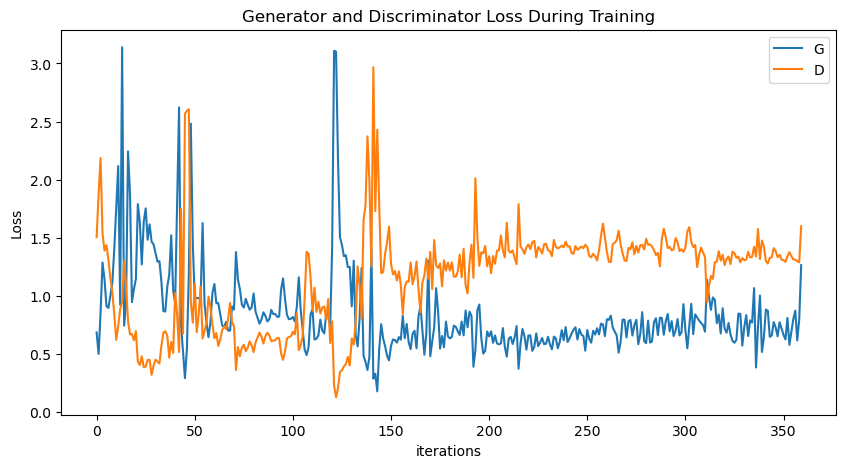

In [8]:
plot_train_metrics(trainer.G_losses, trainer.D_losses)

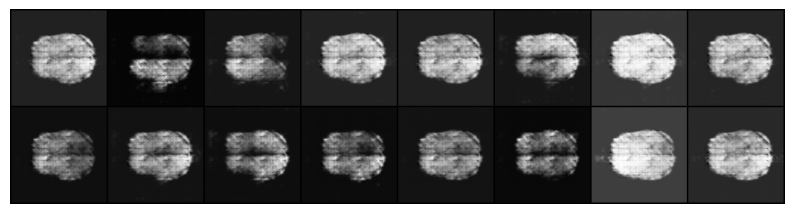

In [9]:
fig = plt.figure(figsize=(10,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in trainer.img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## Save the Trained Model

In [11]:
param_str = f"_{cfg.NUM_EPOCHS}epochs_{cfg.BATCH_SIZE}batch_G_{cfg.LATENT_SZ}z_{cfg.NGF}feat_{cfg.GLR}lr_D_{cfg.NUM_LEVELS}lvl_{cfg.NDF}feat_{cfg.DLR}lr_{cfg.NEG_SLOPE}lRelu"

torch.save(netD, f"models/unetgan/unetgan_netD_{param_str}.pth")
torch.save(netG, f"models/unetgan/unetgan_netG_{param_str}.pth")

param_str = f"_{cfg.NUM_EPOCHS}epochs_{cfg.BATCH_SIZE}batch_G_{cfg.LATENT_SZ}z_{cfg.NGF}feat_{cfg.GLR}lr_D_{cfg.NUM_LEVELS}lvl_{cfg.NDF}feat_{cfg.DLR}lr_{cfg.NEG_SLOPE}lRelu"

netG = torch.load(f"models/unetgan/unetgan_netG_{param_str}.pth")

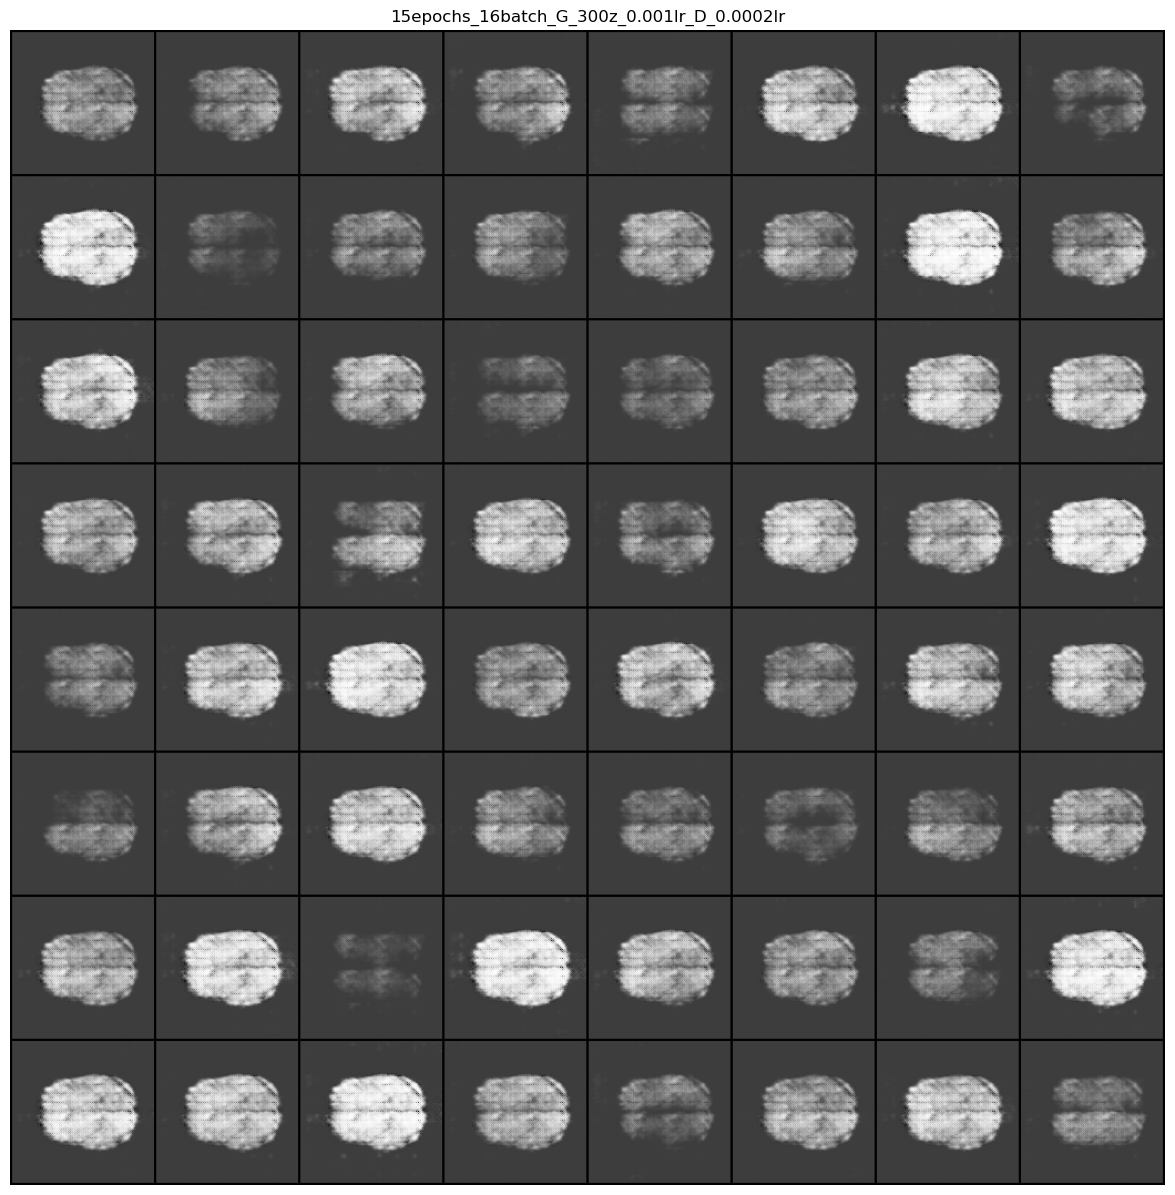

In [10]:
netG.eval()

fixed_noise = torch.randn(36, cfg.LATENT_SZ, 1, 1, device=cfg.DEVICE)

fake = netG(fixed_noise).detach().cpu()

img = np.transpose(
        vutils.make_grid(fake, padding=2, normalize=True),
        (1, 2, 0)
    ).cpu().numpy()
title_str = f"{cfg.NUM_EPOCHS}epochs_{cfg.BATCH_SIZE}batch_G_{cfg.LATENT_SZ}z_{cfg.GLR}lr_D_{cfg.DLR}lr"
plt.figure(figsize=(15,15))
plt.title(title_str)
plt.imshow(img)
plt.axis("off")
plt.imsave(f"output/training/unet_{title_str}.png",img)

### Save the images

In [12]:
fixed_noise = torch.randn(369, cfg.LATENT_SZ, 1, 1, device=cfg.DEVICE)

fake = netG(fixed_noise).detach().cpu()

for i in range(fake.size(0)):
           vutils.save_image(fake[i, :, :, :], f'output/unetgan/{cfg.BT_CLASS.lower()}/{i}.png')